In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.signal import chirp
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
import os, glob

#config
N_SAMPLES = 1000
SAMPLES_PER_CLASS = N_SAMPLES // 3
N_POINTS = 1024
FS = 4e6
DATA_DIR = "rf_dataset"
BATCH_SIZE = 32
EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#synthetic data generation for simulation
os.makedirs(DATA_DIR, exist_ok=True)
np.random.seed(42)
def add_noise(sig, snr_db):
    sig_power = np.mean(np.abs(sig)**2)
    noise_power = sig_power / (10**(snr_db/10))
    noise = np.sqrt(noise_power/2) * (np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))
    return sig + noise

# Zigbee-like
for i in range(SAMPLES_PER_CLASS):
    t = np.arange(N_POINTS) / FS
    f = np.random.uniform(1e6, 1.5e6)
    sig = np.exp(1j * 2*np.pi*f*t)
    sig = add_noise(sig, np.random.uniform(10,25))
    np.save(f"{DATA_DIR}/zigbee_{i}.npy", np.stack((sig.real, sig.imag)))

# BLE-like
for i in range(SAMPLES_PER_CLASS):
    t = np.arange(N_POINTS) / FS
    freqs = np.random.choice([0.8e6, 1.8e6, 2.4e6], size=3)
    sig = sum(np.exp(1j*2*np.pi*f*t + 1j*np.random.uniform(0,np.pi)) for f in freqs)
    sig = add_noise(sig, np.random.uniform(5,20))
    np.save(f"{DATA_DIR}/ble_{i}.npy", np.stack((sig.real, sig.imag)))

# Microwave/noisy
for i in range(SAMPLES_PER_CLASS + N_SAMPLES % 3):
    t = np.arange(N_POINTS) / FS
    bb_noise = (np.random.randn(N_POINTS) + 1j*np.random.randn(N_POINTS)) * 0.6
    chirp_sig = chirp(t, f0=5e5, f1=1.8e6, t1=t[-1], method='linear') * np.exp(1j*np.pi/4)
    sig = bb_noise + chirp_sig
    sig = add_noise(sig, np.random.uniform(0,10))
    np.save(f"{DATA_DIR}/microwave_{i}.npy", np.stack((sig.real, sig.imag)))

print("Synthetic dataset generated and saved to:", DATA_DIR)

spectrum visualisation

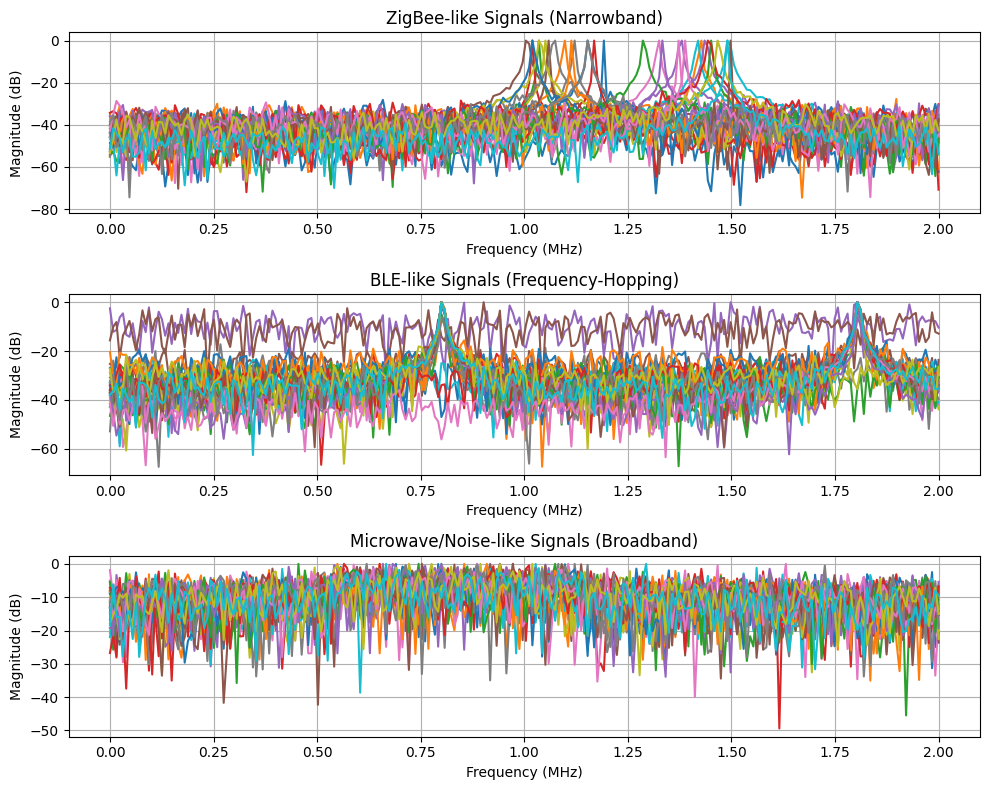

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import glob, os

DATA_DIR = "rf_dataset"
N_FFT = 512
FS = 4e6

def plot_spectrum(file_list, title, subplot_idx):
    plt.subplot(3,1,subplot_idx)
    for f in file_list[:30]:
        x = np.load(f)
        signal = x[0] + 1j*x[1]
        spec = np.abs(fft(signal, N_FFT))[:N_FFT//2]
        freqs = np.linspace(0, FS/2, N_FFT//2)
        plt.plot(freqs/1e6, 20*np.log10(spec/np.max(spec)+1e-9))
    plt.title(title)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)

# Get 5 signals from each category
zigbee_files = sorted(glob.glob(os.path.join(DATA_DIR, "zigbee_*.npy")))[:30]
ble_files     = sorted(glob.glob(os.path.join(DATA_DIR, "ble_*.npy")))[:30]
microwave_files = sorted(glob.glob(os.path.join(DATA_DIR, "microwave_*.npy")))[:30]

plt.figure(figsize=(10,8))
plot_spectrum(zigbee_files, "ZigBee-like Signals (Narrowband)", 1)
plot_spectrum(ble_files, "BLE-like Signals (Frequency-Hopping)", 2)
plot_spectrum(microwave_files, "Microwave/Noise-like Signals (Broadband)", 3)
plt.tight_layout()
plt.show()


In [ ]:
#dsp processing
N_FFT = 256
TOP_BINS = 50

class RFSignalDataset(Dataset):
    def __init__(self, root_dir):
        self.files = glob.glob(os.path.join(root_dir, '*.npy'))
        self.scaler = StandardScaler()

    def __getitem__(self, idx):
        x = np.load(self.files[idx])
        signal = x[0] + 1j*x[1]
        spec = np.abs(fft(signal, N_FFT))[:N_FFT//2]
        top_idx = np.argsort(spec)[-TOP_BINS:]
        features = spec[top_idx]
        features = self.scaler.fit_transform(features.reshape(-1,1)).ravel()
        if 'zigbee' in self.files[idx]:
            label = 0
        elif 'ble' in self.files[idx]:
            label = 1
        else:
            label = 2
        return torch.tensor(features, dtype=torch.float32), label

    def __len__(self):
        return len(self.files)

In [ ]:
#cnn classifier
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(8)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*8, 3)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        return self.fc(x)


In [ ]:
#train/val
dataset = RFSignalDataset(DATA_DIR)
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.2 * n_total)
n_test = n_total - (n_train + n_val)
train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = TinyCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {running_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {100*correct/total:.2f}%")

print("Training complete.")

In [1]:
#testing
model.eval()
test_correct, test_total, test_loss = 0, 0, 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        outputs = model(X)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        preds = outputs.argmax(1)
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)
print(f">>> Test Loss: {test_loss/len(test_loader):.4f} | Test Accuracy: {100*test_correct/test_total:.2f}%")

param_size = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
total_size = (param_size + buffer_size) / (1024**2)
print(f">>> Model size: {total_size:.4f} MB ({total_size/1024:.6f} GB)")


✅ Synthetic dataset generated and saved to: rf_dataset
Epoch 1/100 | Train Loss: 1.0703 | Val Loss: 1.0261 | Val Acc: 34.50%
Epoch 2/100 | Train Loss: 0.9350 | Val Loss: 0.8536 | Val Acc: 58.00%
Epoch 3/100 | Train Loss: 0.7129 | Val Loss: 0.6658 | Val Acc: 64.50%
Epoch 4/100 | Train Loss: 0.5661 | Val Loss: 0.6427 | Val Acc: 64.50%
Epoch 5/100 | Train Loss: 0.5379 | Val Loss: 0.6064 | Val Acc: 64.50%
Epoch 6/100 | Train Loss: 0.5266 | Val Loss: 0.6159 | Val Acc: 62.00%
Epoch 7/100 | Train Loss: 0.5252 | Val Loss: 0.6199 | Val Acc: 75.50%
Epoch 8/100 | Train Loss: 0.5209 | Val Loss: 0.6160 | Val Acc: 64.50%
Epoch 9/100 | Train Loss: 0.5225 | Val Loss: 0.6388 | Val Acc: 65.50%
Epoch 10/100 | Train Loss: 0.5123 | Val Loss: 0.5923 | Val Acc: 62.50%
Epoch 11/100 | Train Loss: 0.5123 | Val Loss: 0.6058 | Val Acc: 66.50%
Epoch 12/100 | Train Loss: 0.5079 | Val Loss: 0.5982 | Val Acc: 65.50%
Epoch 13/100 | Train Loss: 0.5062 | Val Loss: 0.6043 | Val Acc: 67.00%
Epoch 14/100 | Train Loss: 0.50